# Performing a in-plane cell relaxation of a SW-defect with BAFF and MikadoRR

In [1]:
from cgf.utils.geometry import geom_optimize
from cgf.models.surrogate import MikadoRR
from cgf.models.baff import BAFFPotential
from cgf.utils.defects import generate_SW_defect
from cgf.utils.plot import plot_cgatoms
from cgf.cgatoms import init_cgatoms, write_cgatoms

from pathlib import Path
import json
import numpy as np

from ase.io import Trajectory
from ase.constraints import FixedPlane
from ase.filters import FrechetCellFilter
from ase.optimize import BFGS

## 1. Reading in models

We are reading the models from example1 into dictionaries.

Furthermore, we will need again `r0` which is the distance between two core vertex positions and can be extracted directly from the unit cell for a honeycomb lattice.

In [2]:
with open(Path('../example1', 'training_model_BAFF.json')) as f:
    training_model_BAFF = json.load(f)
with open(Path('../example1', 'training_model_MikadoRR.json')) as f:
    training_model_MikadoRR = json.load(f)

traj = Trajectory(Path('../example1', 'traj_training.traj'))
r0 = traj[0].cell.cellpar()[0]/np.sqrt(3)  # works for hexagonal unit cells

## 2. Initializing calculators

Here, we initialize the BAFF and MikadoRR calculators. For MikadoRR, we have additionally the option `opt` which means that internally at each geometry optimization step first the linker-sites are being optimized, i.e. the bending of the beams is updated.

In [3]:
calculator_BAFF = BAFFPotential(r0=r0,
                           Kbond=training_model_BAFF['Kbond'],
                           Kangle=training_model_BAFF['Kangle'],
                           )


calculator_MikadoRR = MikadoRR(r0=r0, 
                      rr_coeff=np.array(training_model_MikadoRR['rr_coeff']), 
                      rr_incpt=training_model_MikadoRR['rr_incpt'], 
                      opt=True,
                      update_linker_sites=True,
                      reevaluate_Topology=False)

# 3. Generating a CG Stone-Wales defect

We are now using a built in function to generate a 3x3 supercell with one stone-wales defect in it. The SW defect is scaled based on a reference cell of a pristine system.

In [4]:
cg_defect = generate_SW_defect(reference_cell=traj[0].copy().cell,
                               supercell_size=(3,3,1))


## 4. Performing a in-plane cell-relaxation with the CG models

In [5]:
cg_defect_BAFF = cg_defect.copy()
cg_defect_BAFF.calc = calculator_BAFF

# for 2D optimization
c = FixedPlane(
    indices=[atom.index for atom in cg_defect],
    direction=[0, 0, 1],  # only move in xy plane
)

cg_defect.set_constraint(c)

ecf = FrechetCellFilter(cg_defect_BAFF, 
                        mask=[True, True, False, False, False, True], # 2D cell optimization
                        hydrostatic_strain=False)
dyn = BFGS(ecf, 
           trajectory=None, 
           logfile=None)

dyn.run(fmax=0.001, steps=1000)
cg_defect_o = cg_defect_BAFF.calc.get_atoms()

Alternatively, we have also implemented a function for the above mentioned steps, called `geom_optimize`:

In [6]:
cg_defect_BAFF = cg_defect.copy()
cg_atoms_o_BAFF = geom_optimize(cg_defect, 
                           calculator_BAFF, 
                           optcell=True, 
                           isotropic=False, 
                           logfile=None, 
                           trajectory=None, 
                           mask=[True, True, False, False, False, True], 
                           fmax=0.001)
print('SW Energy BAFF: ', cg_atoms_o_BAFF.get_potential_energy())



cg_defect_MikadoRR = cg_defect.copy()
# Initializing the cgatoms is only necessary for the MikadoRR model
# This adds to the CG sites automatically neighbor connectivities
# and linker-site vectors
cg_defect_MikadoRR = init_cgatoms(cg_atoms=cg_defect_MikadoRR,
                         r0=r0,
                         linkage_length=training_model_MikadoRR['linkage_length'],
                         )
cg_atoms_o_MikadoRR = geom_optimize(cg_defect_MikadoRR, 
                           calculator_MikadoRR, 
                           optcell=True, 
                           isotropic=False, 
                           logfile=None, 
                           trajectory=None, 
                           mask=[True, True, False, False, False, True], 
                           fmax=0.001)
print('SW Energy MikadoRR: ', cg_atoms_o_MikadoRR.get_potential_energy())
write_cgatoms(cg_atoms_o_MikadoRR, 'cg_atoms_MikadoRR.json')


Relaxation time: 18.16 s
SW Energy BAFF:  21.748901061292724
Relaxation time: 34.48 s
SW Energy MikadoRR:  16.952154251419415


(<Figure size 1000x1000 with 1 Axes>, <Axes: >)

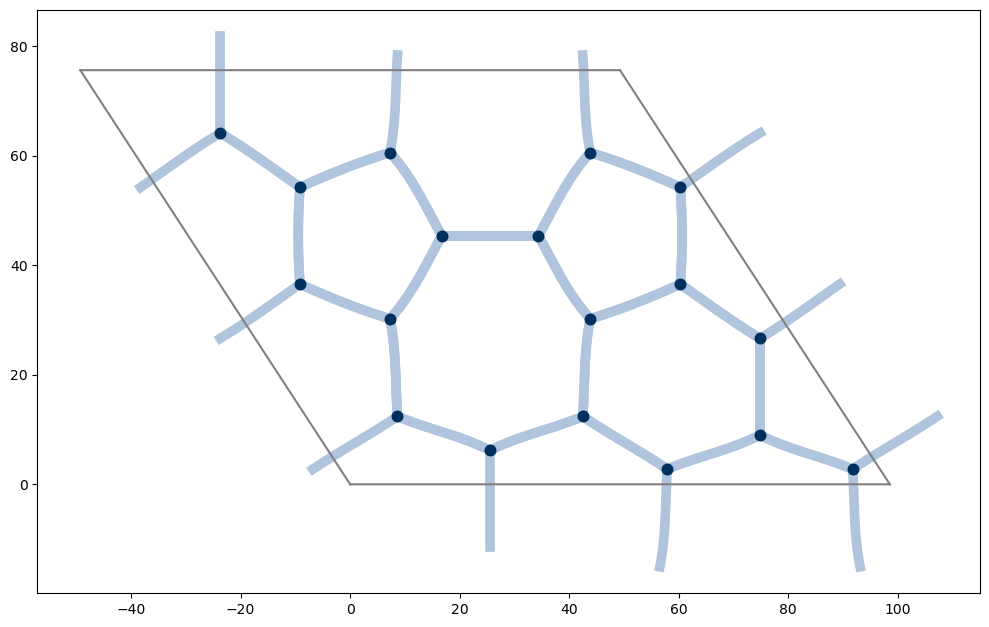

In [7]:
plot_cgatoms(cg_atoms=cg_atoms_o_MikadoRR, plot_linker_sites=False)
